This notebook has the purpose of comparing tidal ellipses calculated by the model to other data sources.

#Loading and Preparing the Files

The following cells in this section will load, mask, rotate and unstagger the model output data. 

In [2]:
import os
import glob
import datetime
import matplotlib.pylab as plt
import matplotlib.ticker as ticker
from matplotlib.patches import Ellipse
from math import sin, cos, sqrt, atan2, radians
import numpy as np
from IPython.display import display, Math, Latex
import datetime
import pandas as pd
import seaborn as sn

import netCDF4 as nc
from scipy.optimize import curve_fit
from salishsea_tools import (viz_tools, tidetools, nc_tools)
from salishsea_tools.nowcast import (research_VENUS, analyze)

%matplotlib inline

In [3]:
grid_B = nc.Dataset('/data/dlatorne/MEOPAR/NEMO-forcing/grid/bathy_meter_SalishSea2.nc')
lats = grid_B.variables['nav_lat'][:]
lons = grid_B.variables['nav_lon'][:]
bathy = grid_B.variables['Bathymetry'][:,:]
sn.set_style('darkgrid') 

In [4]:
to = datetime.datetime(2014,11,26)
tf = datetime.datetime(2015, 7, 13)

t_o = to.strftime('%d%b%y').lower()
t_f = tf.strftime('%d%b%y').lower()

runname1 = '{}_{}_Central'.format(t_o, t_f)
runname2 = '{}_{}_East'.format(t_o, t_f)


cols=np.arange(0,9)

df1 = pd.read_csv('TidalEllipseData/Nodes/'+runname1+'.csv', usecols=cols) 
df2 = pd.read_csv('TidalEllipseData/Nodes/'+runname2+'.csv', usecols=cols)

cen = df1.as_matrix()
east = df2.as_matrix()

In [5]:
to = datetime.datetime(2014,11,26)
tf = datetime.datetime(2015, 7, 13)

t_o = to.strftime('%d%b%y').lower()
t_f = tf.strftime('%d%b%y').lower()

runname1 = '{}_{}_Central_depav'.format(t_o, t_f)
runname2 = '{}_{}_East_depav'.format(t_o, t_f)

#Only importing M2 parameters
cols=np.arange(0,1)

df1 = pd.read_csv('TidalEllipseData/Nodes/'+runname1+'.csv', index_col=False) 
df2 = pd.read_csv('TidalEllipseData/Nodes/'+runname2+'.csv', index_col=False)

cen_av = df1.as_matrix()
east_av = df2.as_matrix()

The locations of the nodes are stored in a dictionary in research_VENUS.py

Slice in order to compare, the min and max depth values for each location is determine by the comparison source.

#Location

We are using the nearest grid point to determine where to calculate ellipses for the comparisons. However the closest grid point may not be the most comparable grid point because of the quick change in bathymetry in this area.

* Central --
Longitude: 123° 25.562
Latitude: 49° 02.412
Depth(m): 300

* East --
Longitude(W): 123° 18.996
Latitude(N): 49° 02.572
Depth(m): 170 

In [6]:
ic = research_VENUS.SITES['VENUS']['Central']['i']
jc = research_VENUS.SITES['VENUS']['Central']['j']

lonc = lons[jc,ic]
latc = lats[jc,ic]
latitudec = 49.0402
longitudec = -123.426033

In [7]:
ie = research_VENUS.SITES['VENUS']['East']['i']
je = research_VENUS.SITES['VENUS']['East']['j']

lone = lons[je,ie]
late = lats[je,ie]
latitudee = 49.04286
longitudee = -123.3166

In [8]:
# approximate radius of earth in km
R = 6373.0

lat1 = radians(latc)
lon1 = radians(lonc)
lat2 = radians(latitudec)
lon2 = radians(longitudec)

dlon = lon2 - lon1
dlat = lat2 - lat1

a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
c = 2 * atan2(sqrt(a), sqrt(1 - a))

distance = R * c

print("Result:", distance*1000, 'm')

('Result:', 216.9883863595708, 'm')


In [9]:
# approximate radius of earth in km
R = 6373.0

lat1 = radians(late)
lon1 = radians(lone)
lat2 = radians(latitudee)
lon2 = radians(longitudee)

dlon = lon2 - lon1
dlat = lat2 - lat1

a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
c = 2 * atan2(sqrt(a), sqrt(1 - a))

distance = R * c

print("Result:", distance*1000, 'm')

('Result:', 255.38403369948009, 'm')


Both are over 200m away from the nodes. Maybe we can find a grid point with a similar distance but more comparible depth.

In [10]:
depc = bathy[jc,ic]
depe = bathy[je,ie]
print ('Central:', depc, 'East:',depe)
print ('Should be: Central:',300,'East:',170)

('Central:', 306.0, 'East:', 170.0)
('Should be: Central:', 300, 'East:', 170)


They are at a resonaly similar depths and when I try for other grid point in the vicinity two of the grid point in the vicinity are closer to 300m but they are over 400m away. I think the grid point we have chosen, the nearest ones, is a good approximation.

#Fits

The following cells will calculate the cell-centered model output velocities' tidal parameters.

#Comparisons
##Depth Averaged at VENUS nodes 

Mark Halverson's values:

In [11]:
node = [[0.177, 0.006, 109, 311, 0.106, 0.007, 112, 188],[ 0.262, -0.005, 125, 320, 0.175, -0.011, 122, 220]]
#CODAR values
codar = [[0.113, 0.008, 126, 273,0.074, 0.006, 134, 131],[0.138, -0.037, 134, 282, 0.077, -0.009, 129, 187]]

The nodes were depth averaged between 35 - 290 m at the Central node and 20 - 160 m at the East node. I have done the same with the model output. Note that the node values wer averaged about 10-11 months where are the model output values were averages over 6 1/2 months (Nov 24, 2014 to June 8, 2015).

In [12]:
print "          Major-Axis   Minor-Axis     Angle       Phase"
print "            (m/s)        (m/s)     (deg ccw E)    (deg)"  
print "M2 - Central (35-290m)"
print ' Model      {0:.2f}        {1:6.3f}        {2:.0f}          {3:.0f}  '.format( 
         cen_av[0,0], cen_av[0,1], cen_av[0,2], cen_av[0,3]) 
print ' Nodes      {0:.2f}        {1:6.3f}        {2:.0f}          {3:.0f} '.format(
         node[0][0], node[0][1], node[0][2], node[0][3])
print ""
print "M2 - East (20-160m)"
print ' Model      {0:.2f}        {1:5.3f}        {2:.0f}          {3:.0f}  '.format( 
         east_av[0,0], east_av[0,1], east_av[0,2], east_av[0,3]) 
print ' Nodes      {0:.2f}        {1:5.3f}        {2:.0f}          {3:.0f} '.format(
         node[1][0], node[1][1], node[1][2], node[1][3])
print ""
print "K1 - Central (35-290m)"
print ' Model      {0:.2f}        {1:6.3f}        {2:.0f}          {3:.0f}  '.format( 
         cen_av[0,4], cen_av[0,5], cen_av[0,6], cen_av[0,7]) 
print ' Nodes      {0:.2f}        {1:6.3f}        {2:.0f}          {3:.0f} '.format(
         node[0][4], node[0][5], node[0][6], node[0][7])
print ""
print "K1 - East (20-160m)"
print ' Model      {0:.2f}        {1:5.3f}        {2:.0f}          {3:.0f}  '.format( 
         east_av[0,4], east_av[0,5], east_av[0,6], east_av[0,7]) 
print ' Nodes      {0:.2f}        {1:5.3f}        {2:.0f}          {3:.0f} '.format(
         node[1][4], node[1][5], node[1][6], node[1][7])


          Major-Axis   Minor-Axis     Angle       Phase
            (m/s)        (m/s)     (deg ccw E)    (deg)
M2 - Central (35-290m)
 Model      0.16         0.013        130          305  
 Nodes      0.18         0.006        109          311 

M2 - East (20-160m)
 Model      0.29        -0.017        137          324  
 Nodes      0.26        -0.005        125          320 

K1 - Central (35-290m)
 Model      0.08         0.005        135          184  
 Nodes      0.11         0.007        112          188 

K1 - East (20-160m)
 Model      0.19        -0.025        131          226  
 Nodes      0.17        -0.011        122          220 


##Plotting ellipses

In [14]:
font = {'family' : 'Arial',
    'weight' : 'normal',
    'size'   : 20}
axisfont = {'family' : 'Arial',
    'weight' : 'light',
    'size'   : 16}

In [15]:
def plot_ellipse_comparison(model_c, model_e, scale, source, k1=False):

    phi=29
    k = np.zeros((898,398)); m = np.zeros((898,398))
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)
    viz_tools.set_aspect(ax) 
    ex = 90

    #Inverted i and j to match code
    sites = research_VENUS.SITES
    ic = sites['VENUS']['Central']['i']
    ie = sites['VENUS']['East']['i']
    jc = sites['VENUS']['Central']['j']
    je = sites['VENUS']['East']['j']


    for i in np.arange(je-ex,jc+ex):
        for j in np.arange(ic-ex,ie+ex):
            k[i,j] = i*np.cos(phi*np.pi/180.)+j*np.sin(phi*np.pi/180.)
            m[i,j] = -i*np.sin(phi*np.pi/180.)+j*np.cos(phi*np.pi/180.) 

    if k1:
        k1=4
    else:
        k1=0
    
    if source == 'Surface':
        d = 1
        obs = codar
    else:
        d = 0
        obs = node
        
    maj = [model_c[0,0+k1+d], obs[0][0+k1], model_e[0,0+k1+d], obs[1][0+k1]]
    mino = [model_c[0,1+k1+d], obs[0][1+k1], model_e[0,1+k1+d], obs[1][1+k1]]
    inc = [model_c[0,2+k1+d], obs[0][2+k1], model_e[0,2+k1+d], obs[1][2+k1]]
    loc = [(jc,ic),(jc,ic), (je,ie),(je,ie)]
    intens = [1, 0.8, 1, 0.8]; opaque = [1,0.3,1,0.3]
    label = ['Salish Sea Model', 'ADCP', 'd', 'sv']

    for  maj, mino, inc, loc, intens, opaque, label in zip(maj, mino, inc, loc, intens, opaque, label):
        if mino > 0:
            thec = [0,0,1*intens, opaque]
        else:
            thec = [1*intens,0,0, opaque]
        ellsc = Ellipse(xy=(m[loc],k[loc]), width=scale*maj, 
                            height=scale*mino, angle=inc,
                            color=thec)
        ax.add_artist(ellsc)
        ellsc.set_facecolor(thec)

    ell = Ellipse(xy=(m[395,190],k[395,190]),width = scale*0.2, height = scale*0.05, angle = -45,
                  color='g')
    ax.add_artist(ell)
    textscale = ax.text(m[405,190],k[405,190], '0.2 m/s', color='g', fontsize=12)
    # y-axis in k, but labelled in latitude
    ax.set_ylim(480,490)
    slope = (lats[jc,ic]-lats[je,ic])/(k[jc,ic]-k[je,ic])
    mylist = (k[je,ic]+(np.arange(48.7, 49.35, 0.1)-
                               lats[je,ic])/slope).tolist()
    labels = ['48.7','48.8', '48.9', '49', '49.1', '49.2', '49.3']
    ax.set_yticks(mylist)
    ax.set_yticklabels(labels)
    ax.set_ylabel('Latitude (degrees N)', **axisfont)
    # x-axis in m, but labelled in longitude
    ax.set_xlim(100,120)
    slope = (lons[je,ie]-lons[je,ic])/(m[je,ie]-m[je,ic])
    mylist = (m[je,ic]+(np.arange(-123.8,-122.85,0.1)-
                            lons[je,ic])/slope).tolist()
    labels = ['123.8','123.7','123,6','123.5','123.4','123.3', '123.2', '123.1', '123','122.9']
    ax.set_xticks(mylist)
    ax.set_xticklabels(labels)
    ax.tick_params(axis='both', which='major', labelsize=14)
    ax.set_xlabel('Longitude (degrees W)', **axisfont)


    # land, and 5 m contour
    contour_interval = [-0.01, 0.01]
    ax.contourf(m[je-ex:jc+ex,ic-ex:ie+ex],k[je-ex:jc+ex,ic-ex:ie+ex],
                bathy.data[je-ex:jc+ex,ic-ex:ie+ex],contour_interval,colors='black')
    ax.contour(m[je-ex:jc+ex,ic-ex:ie+ex],k[je-ex:jc+ex,ic-ex:ie+ex],
                bathy.data[je-ex:jc+ex,ic-ex:ie+ex],[5],colors='black')
    if k1==4:
        ax.set_title('{data} K1 tidal ellipses at VENUS nodes'.format(data=source), **font)
    else:
        ax.set_title('{data} M2 tidal ellipses at VENUS nodes'.format(data=source), **font)

    print "red is clockwise"
    return fig

red is clockwise


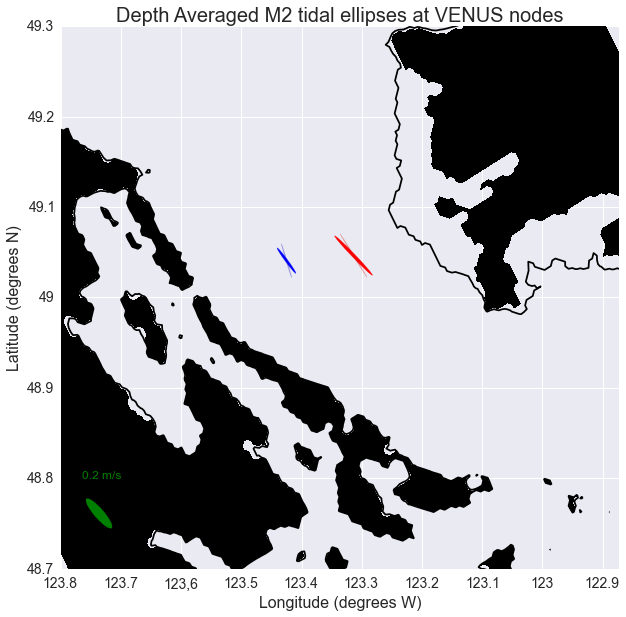

In [16]:
fig = plot_ellipse_comparison(cen_av, east_av, 50, 'Depth Averaged')

red is clockwise


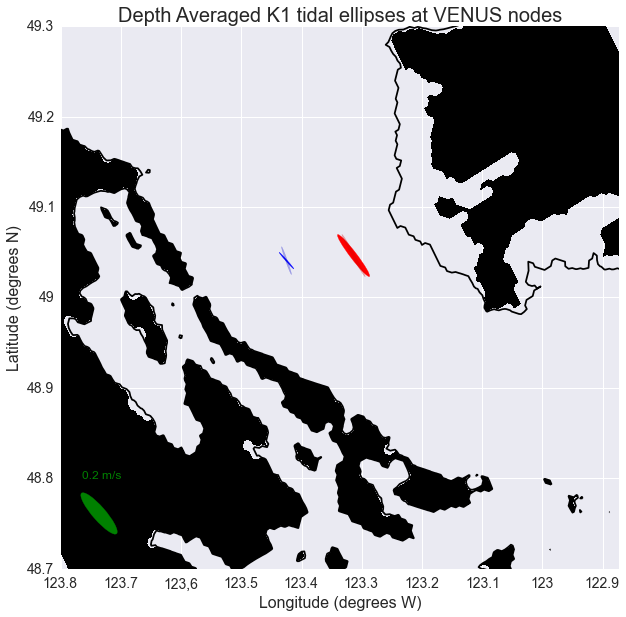

In [17]:
fig = plot_ellipse_comparison(cen_av, east_av, 70, 'Depth Averaged', k1=True)

##Surface comparisons with CODAR

The CODAR region evaluates only the currents in the first meter of the water column. These values are compared with the 0.5 m depth model outputs.

In [13]:
print "          Major-Axis   Minor-Axis     Angle       Phase"
print "            (m/s)        (m/s)     (deg ccw E)    (deg)"  
print "M2 - Central (0.5m)"
print ' Model      {0:.2f}        {1:6.3f}        {2:.0f}          {3:.0f}  '.format( 
         cen[0,1], cen[0,2], cen[0,3], cen[0,4]) 
print ' CODAR      {0:.2f}        {1:6.3f}        {2:.0f}          {3:.0f} '.format(
         codar[0][0], codar[0][1], codar[0][2], codar[0][3])
print ""
print "M2 - East (0.5m)"
print ' Model      {0:.2f}        {1:5.3f}        {2:.0f}          {3:.0f}  '.format( 
         east[0,1], east[0,2], east[0,3], east[0,4]) 
print ' CODAR      {0:.2f}        {1:5.3f}        {2:.0f}          {3:.0f} '.format(
         codar[1][0], codar[1][1], codar[1][2], codar[1][3])
print ""
print "K1 - Central (0.5m)"
print ' Model      {0:.2f}        {1:6.3f}        {2:.0f}          {3:.0f}  '.format( 
         cen[0,5], cen[0,6], cen[0,7], cen[0,8]) 
print ' CODAR      {0:.2f}        {1:6.3f}        {2:.0f}          {3:.0f} '.format(
         codar[0][4], codar[0][5], codar[0][6], codar[0][7])
print ""
print "K1 - East (0.5m)"
print ' Model      {0:.2f}        {1:6.3f}        {2:.0f}          {3:.0f}  '.format( 
         east[0,5], east[0,6], east[0,7], east[0,8]) 
print ' CODAR      {0:.2f}        {1:6.3f}        {2:.0f}          {3:.0f} '.format(
         codar[1][4], codar[1][5], codar[1][6], codar[1][7])

          Major-Axis   Minor-Axis     Angle       Phase
            (m/s)        (m/s)     (deg ccw E)    (deg)
M2 - Central (0.5m)
 Model      0.20        -0.076        135          317  
 CODAR      0.11         0.008        126          273 

M2 - East (0.5m)
 Model      0.39        -0.187        125          296  
 CODAR      0.14        -0.037        134          282 

K1 - Central (0.5m)
 Model      0.07        -0.001        111          187  
 CODAR      0.07         0.006        134          131 

K1 - East (0.5m)
 Model      0.11         0.009        107          191  
 CODAR      0.08        -0.009        129          187 


red is clockwise


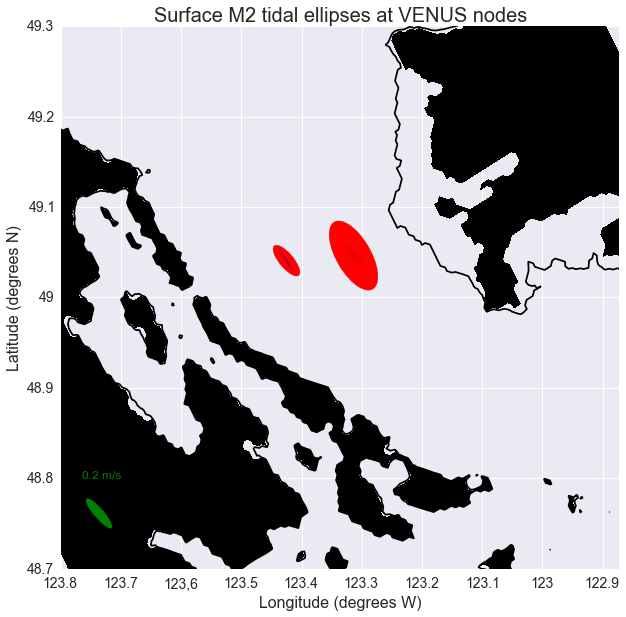

In [18]:
fig = plot_ellipse_comparison(cen, east, 50, 'Surface', k1=False)

red is clockwise


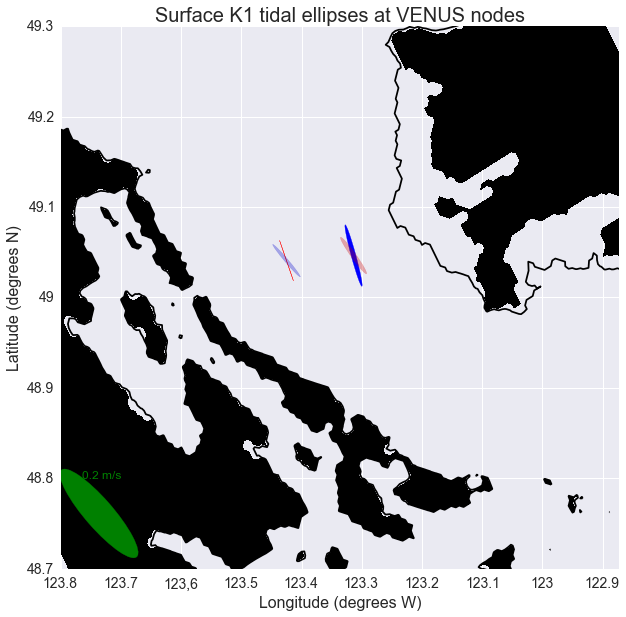

In [19]:
fig = plot_ellipse_comparison(cen, east, 150, 'Surface', k1=True)

This seems like it is affected by the freshet. Let's take a look at this comparison but with data from November 26th 2014 to April 26th 2015

In [20]:
to = datetime.datetime(2014,11,26)
tf = datetime.datetime(2015, 4, 26)

t_o = to.strftime('%d%b%y').lower()
t_f = tf.strftime('%d%b%y').lower()

runname1 = '{}_{}_{}_Central'.format(t_o, t_f, 'h')
runname2 = '{}_{}_{}_East'.format(t_o, t_f, 'h')

df1 = pd.read_csv('/ocean/mdunn/MEOPAR/analysis/Muriel/TidalEllipseData/Sensitivity/'+runname1+'.csv', index_col=False) 
df2 = pd.read_csv('/ocean/mdunn/MEOPAR/analysis/Muriel/TidalEllipseData/Sensitivity/'+runname2+'.csv', index_col=False)

cen_cod = df1.as_matrix()
east_cod = df2.as_matrix()

The freshet is not affectecting the surface currents as much as expected, they are just very large! 

In [21]:
print "Central   Major-Axis   Minor-Axis     Angle"
print "           (m/s)      (m/s)     (deg ccw E)"  
print ' Model      {0:.2f}       {1:5.2f}      {2:3.0f}   '.format( 
         cen_cod[0,1], cen_cod[0,2], cen_cod[0,3]) 
print ' CODAR      {0:.2f}       {1:5.2f}      {2:3.0f}   '.format(
         codar[0][0], codar[0][1], codar[0][2])


print "East   Major-Axis   Minor-Axis     Angle"
print "           (m/s)      (m/s)     (deg ccw E)"  
print ' Model      {0:.2f}       {1:5.2f}      {2:3.0f}   '.format( 
         east_cod[0,1], east_cod[0,2], east_cod[0,3]) 
print ' CODAR      {0:.2f}       {1:5.2f}      {2:3.0f}   '.format(
         codar[1][0], codar[1][1], codar[1][2])

Central   Major-Axis   Minor-Axis     Angle
           (m/s)      (m/s)     (deg ccw E)
 Model      0.19       -0.06      139   
 CODAR      0.11        0.01      126   
East   Major-Axis   Minor-Axis     Angle
           (m/s)      (m/s)     (deg ccw E)
 Model      0.39       -0.16      129   
 CODAR      0.14       -0.04      134   


red is clockwise


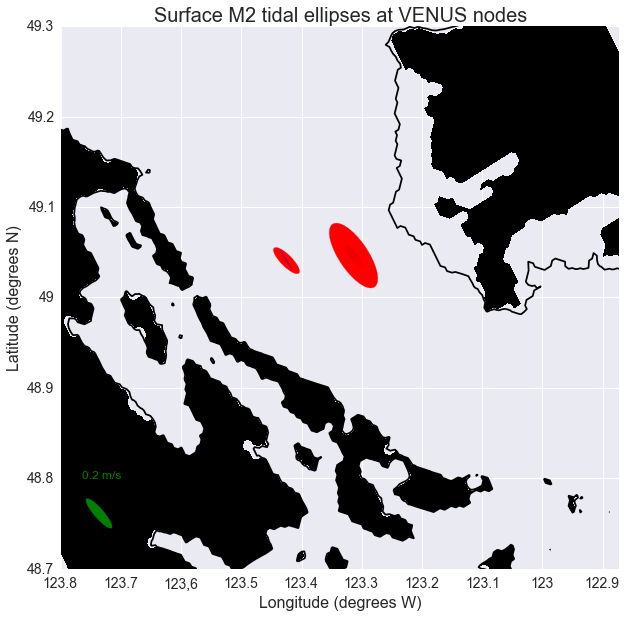

In [22]:
fig = plot_ellipse_comparison(cen_cod, east_cod, 50, 'Surface', k1=False)

red is clockwise


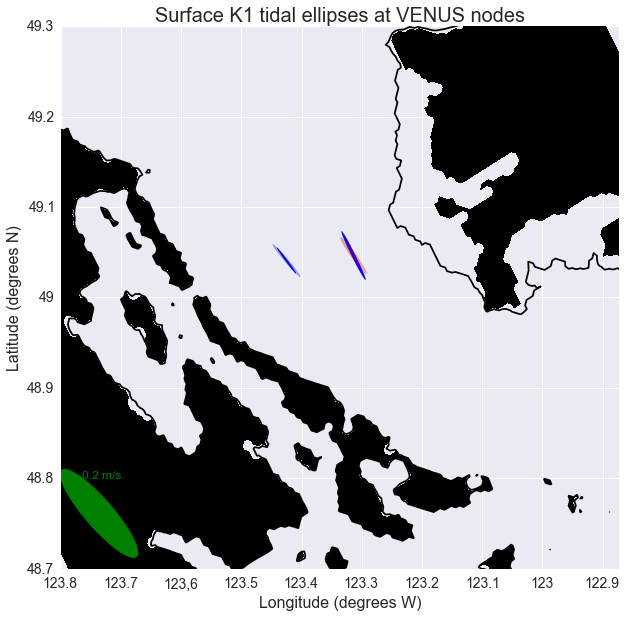

In [23]:
fig = plot_ellipse_comparison(cen_cod, east_cod, 150, 'Surface', k1=True)

##Depth profile comparison

For this comparison I will use ADCP data compiled by Rich Pawlovich and Mark Halverson at the ONC VENUS nodes.

In [24]:
eastobs = np.loadtxt('/ocean/mhalvers/research/adcp/east_ADCP_M2_ellipse_params.txt', skiprows=2, unpack=True)
central = np.loadtxt('/ocean/mhalvers/research/adcp/central_ADCP_M2_ellipse_params.txt', skiprows=2, unpack=True)

In [25]:
x = np.where(np.logical_and(cen[:,0] > central[0,1], cen[:,0] < central[0,-1]))
y = np.where(np.logical_and(east[:,0] > eastobs[0,1], east[:,0] < eastobs[0,-1]))

###Central node

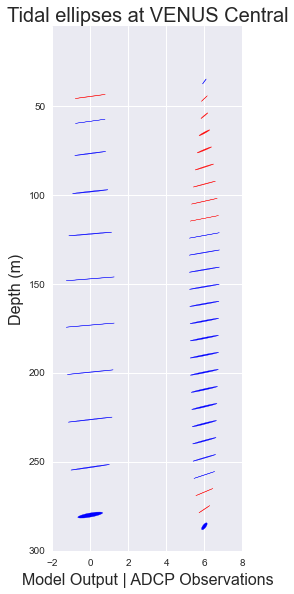

In [26]:
fig = plt.figure(figsize=(7.5,9.4))
ax = fig.add_subplot(121)
scale = 20
interval = 2

for ind, dep in zip(x[0],cen[x[0],0]):
    if cen[ind,2] > 0:
        thec = 'b'
    else:
        thec = 'r'
    ells = Ellipse(xy=(0,dep), width=scale*cen[ind,1], 
                        height=scale*cen[ind,2], angle=cen[ind,3],
                        color=thec)
    ax.add_artist(ells)
    ells.set_facecolor(thec)
    
for ind, dep in zip(np.arange(0,(len(central[0,:])-1), interval), central[0,:][::interval]):
    if central[2,ind] > 0:
        thec = 'b'
    else:
        thec = 'r'
    ells = Ellipse(xy=(6,dep), width=scale*central[1,ind]/100, 
                        height=scale*central[2,ind]/100, angle=central[3,ind],
                        color=thec)
    ax.add_artist(ells)
    ells.set_facecolor(thec)
ax.set_ylim(5,300)
ax.invert_yaxis()
ax.set_xlim(-2,8)
ax.set_title('Tidal ellipses at VENUS Central', **font)
ax.set_ylabel('Depth (m)', **axisfont)
ax.set_xlabel('Model Output | ADCP Observations', **axisfont)

### East node

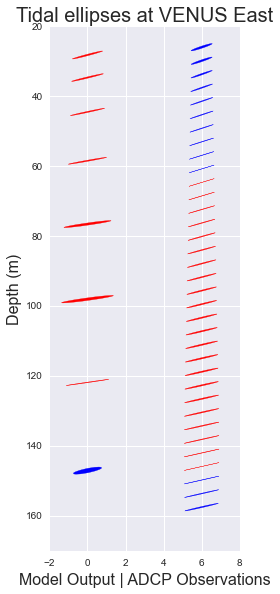

In [27]:
fig = plt.figure(figsize=(7.5,9.4))
ax = fig.add_subplot(121)
scale = 10
interval = 2

for ind, dep in zip(y[0],east[y[0],0]):
    if east[ind,2] > 0:
        thec = 'b'
    else:
        thec = 'r'
    ells = Ellipse(xy=(0,dep), width=scale*east[ind,1], 
                        height=scale*east[ind,2], angle=east[ind,3],
                        color=thec)
    ax.add_artist(ells)
    ells.set_facecolor(thec)
    
for ind, dep in zip(np.arange(0,(len(eastobs[0,:])-1), interval), eastobs[0,:][::interval]):
    if eastobs[2,ind] > 0:
        thec = 'b'
    else:
        thec = 'r'
    ells = Ellipse(xy=(6,dep), width=scale*eastobs[1,ind]/100, 
                        height=scale*eastobs[2,ind]/100, angle=eastobs[3,ind],
                        color=thec)
    ax.add_artist(ells)
    ells.set_facecolor(thec)
ax.set_ylim(20,170)
ax.invert_yaxis()
ax.set_xlim(-2,8)
ax.set_title('Tidal ellipses at VENUS East', **font)
ax.set_ylabel('Depth (m)', **axisfont)
ax.set_xlabel('Model Output | ADCP Observations', **axisfont)

In [28]:
central[1:3,:] = central[1:3,:]/100
eastobs[1:3,:] = eastobs[1:3,:]/100

##Line plots
These will help represent the parameters in the plots above individually without having to look through a table

In [29]:
count = np.arange(0,2)
parameter = ['Major-axis', 'Minor-axis', 'Inclination', 'Phase']
unit = ['m/s','m/s','deg', 'deg']

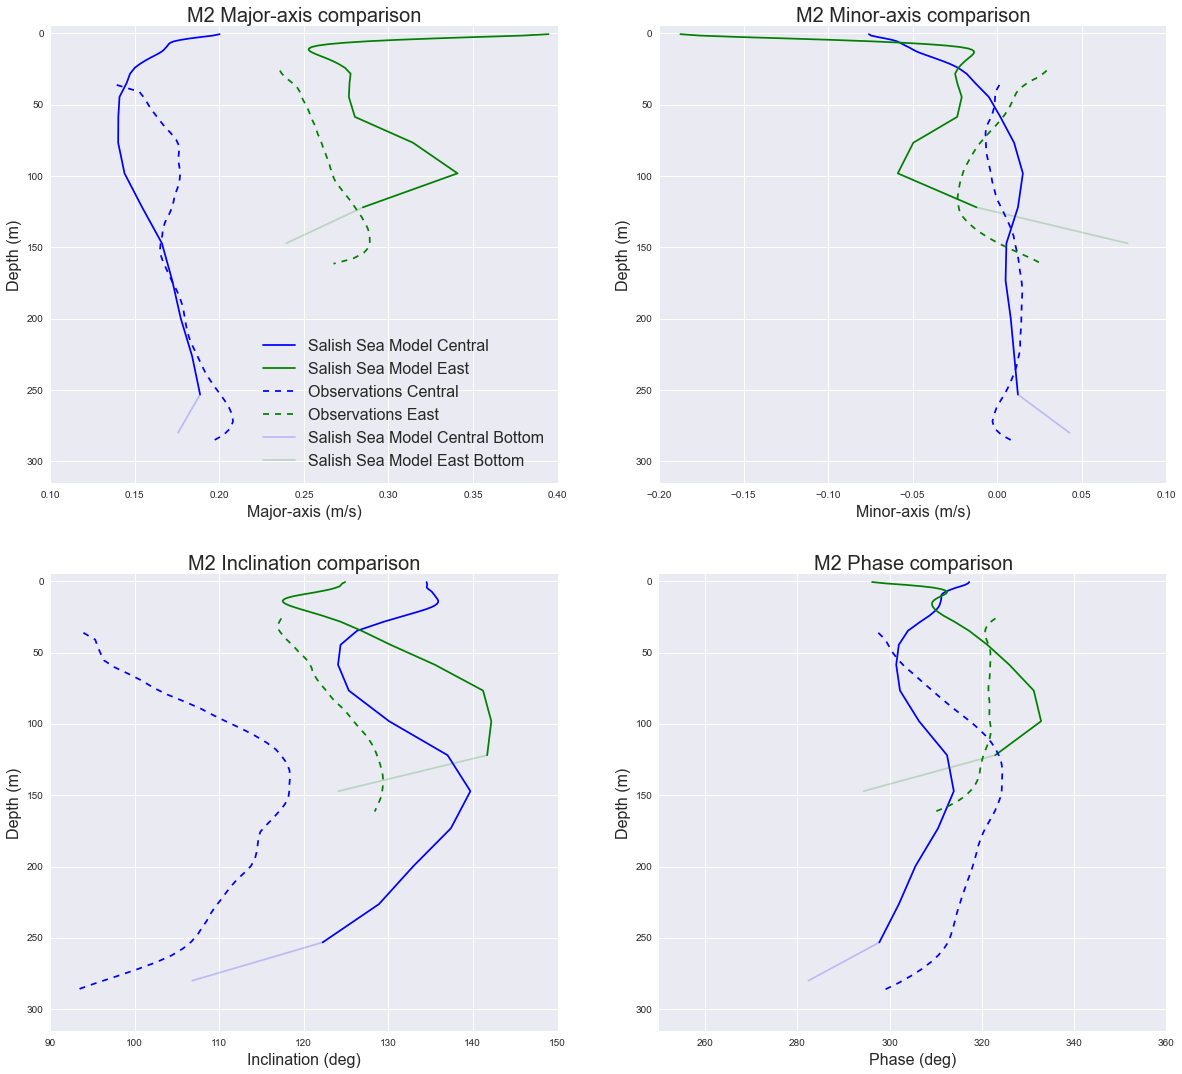

In [48]:
fig, ([ax0, ax1],[ ax2, ax3])= plt.subplots(2,2,figsize=(20,18))

for ax , ind, par, u in zip([ax0, ax1, ax2, ax3], np.arange(1,5), parameter, unit):
    if ax ==ax3:
        ax.set_xlim([250, 360])
    ax.plot(cen[:-6,ind],cen[:-6,0], '-b', label='Salish Sea Model Central')
    ax.plot(east[:-11,ind], east[:-11,0],'-g', label='Salish Sea Model East')
    ax.plot(central[ind,:],central[0,:], '--b', label='Observations Central')
    ax.plot(eastobs[ind,:],eastobs[0,:], '--g', label='Observations East')
    ax.plot(cen[-7:-5,ind],cen[-7:-5,0], '-b', alpha=0.2, label='Salish Sea Model Central Bottom')
    ax.plot(east[-12:-10,ind], east[-12:-10,0],'-g', alpha=0.2, label='Salish Sea Model East Bottom')
    
    ax.set_title('M2 {} comparison'.format(par), **font)
    ax.set_ylabel('Depth (m)',**axisfont)
    ax.set_xlabel('{} ({})'.format(par,u),**axisfont)
    ax.set_ylim([-5, 315])
    ax.invert_yaxis()
    
ax0.legend(loc=0, fontsize=16)

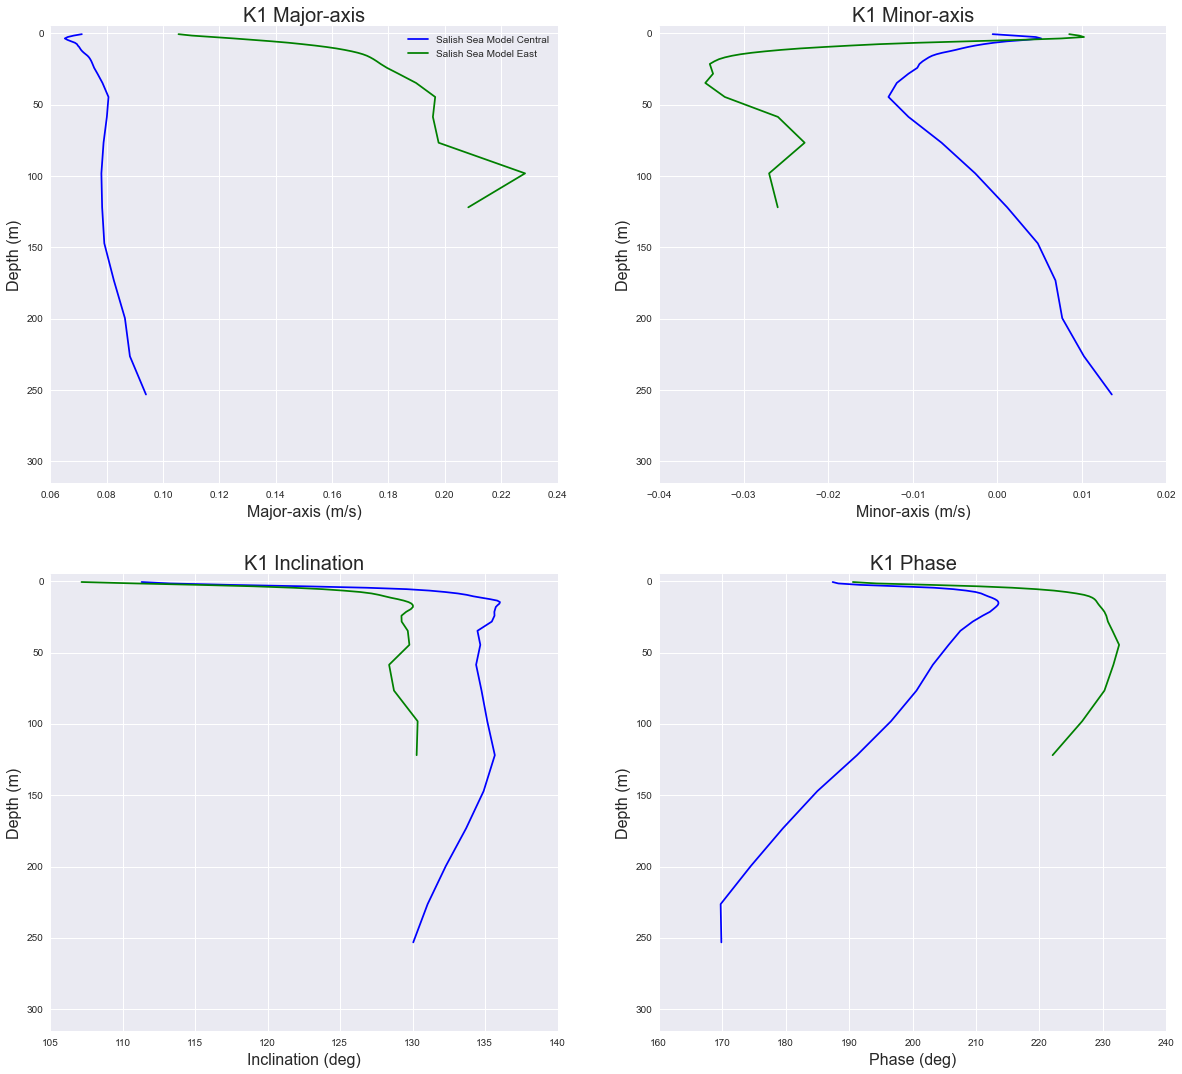

In [31]:
fig, ([ax0, ax1],[ ax2, ax3])= plt.subplots(2,2,figsize=(20,18))

for ax , ind, par, u in zip([ax0, ax1, ax2, ax3], np.arange(5,9), parameter, unit):
    ax.plot(cen[:-6,ind],cen[:-6,0], '-b', label='Salish Sea Model Central')
    ax.plot(east[:-11,ind], east[:-11,0],'-g', label='Salish Sea Model East')
    ax.set_title('K1 {}'.format(par), **font)
    ax.set_ylabel('Depth (m)', **axisfont)
    ax.set_xlabel('{} ({})'.format(par,u), **axisfont)
    ax.set_ylim([-5, 315])
    ax.invert_yaxis()
#ax3.set_xlim([0, 360])    
ax0.legend(loc=0)